In [1]:
%%HTML
<style> code {background-color : lightblue !important;} </style>

In [2]:
#Run the code in the cell below to extract object points 
#and image points for camera calibration.
import numpy as np
import cv2
import glob
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [3]:
# Camera Calibration and Image undistortion functions

def calibrate_camera(path = 'camera_cal/calibration*.jpg'):

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    #path = 'camera_cal/calibration*.jpg'
    images = glob.glob(path)
    #image_count = 1
    #fig = plt.figure()
    #total_num_of_images = len(images)

    nx = 9 #inside x corners
    ny = 6 #inside y corners
    
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)

    # Step through the list and search for chessboard corners
    for idx, fname in enumerate(images):
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)  
            '''
            ax = fig.add_subplot(math.ceil(total_num_of_images / 2), 2, image_count)
            chessboard_with_corners = cv2.drawChessboardCorners(img, (nx, ny), corners, retval)
            chessboard_with_corners = cv2.cvtColor(chessboard_with_corners, cv2.COLOR_BGR2RGB)
            ax.imshow(chessboard_with_corners)
            ax.axis('off')
            image_count += 1
            '''
        #else:
            #print('findChessboardCorners failed:', fname)

    return cv2.calibrateCamera(objpoints, imgpoints, img.shape[0:2], None, None)#, fig

def get_undistorted_img(img, mtx, dist):
    undistorted_img = cv2.undistort(img, mtx, dist)
    return undistorted_img

def calibrate_camera_and_get_undistorted_img(cal_path='camera_cal/calibration*.jpg', test_img='camera_cal/calibration1.jpg'):
    
    #Caliberate the camera and compute the camera matrix and distortion coefficients
    ret, mtx, dist, rvecs, tvecs = calibrate_camera(cal_path)
    
     # Test undistortion on an image
    img = mpimg.imread(test_img)
    # img_size = (img.shape[1], img.shape[0])

    undistorted_img = get_undistorted_img(img, mtx, dist)
    return undistorted_img

    #cv2.imwrite('camera_cal/pattern.jpg',undistorted_img)

In [4]:
# Testing - Visualize undistortion
img = mpimg.imread('test_images/test6.jpg')
test_img = 'test_images/test6.jpg'
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(calibrate_camera_and_get_undistorted_img('camera_cal/calibration*.jpg', test_img))
ax2.set_title('Undistorted Image', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#plt.savefig("combined_signs_vehicles_xygrad.png")
plt.show()

In [5]:
# Color functions
def get_grayscale_img(img):
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) #since image was read using mpimg.imread()
    return grayscale_img
    #gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if image was read using cv2.imread()

def get_hls_image(img): 
    #img = np.copy(img) 
    hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float) 
    return hls_img

def gradient_threshold(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    gray_img = get_grayscale_img(img)
    # Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel_value = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    elif orient == 'y':
        sobel_value = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    else:
        print("You must specify an orientation - x or y")
    # Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_value)
    # Scale to 8-bit (0 - 255) then convert to type = np.uint8
    max_sobel = np.max(abs_sobel)
    scaled_sobel = np.uint8(255*abs_sobel/max_sobel)
    # Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    # Return this mask as your binary_output image
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #grad_binary = np.copy(img) # Remove this line
    return grad_binary

def magnitude_threshold(img, sobel_kernel=9, mag_thresh=(30, 255)):
    gray_img = get_grayscale_img(img)
    # 2) Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the gradient magnitude 
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_8bit_magnitude = np.uint8(255*magnitude/np.max(magnitude))
    # 5) Create a binary mask where mag thresholds are met
    mag_binary = np.zeros_like(scaled_8bit_magnitude)
    mag_binary[(scaled_8bit_magnitude >= mag_thresh[0]) & (scaled_8bit_magnitude <= mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #mag_binary = np.copy(img) # Remove this line
    return mag_binary

#def direction_threshold(img, sobel_kernel=15, thresh=(0.7, np.pi/2)):
def direction_threshold(img, sobel_kernel=15, thresh=(0.7, 1.2)):
    #print(np.pi/2)
    gray_img = gray_img = get_grayscale_img(img)
    # Take the gradient in x and y separately
    sobel_x = cv2.Sobel(gray_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the x and y gradients
    abs_sobel_x = np.absolute(sobel_x)
    abs_sobel_y = np.absolute(sobel_y)
    # Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    gradient_dir = np.arctan2(abs_sobel_y, abs_sobel_x)
    gradient_dir = np.absolute(gradient_dir)
    # Create a binary mask where direction thresholds are met
    dir_binary = np.zeros_like(gradient_dir)
    dir_binary[(gradient_dir >= thresh[0]) & (gradient_dir <= thresh[1])] = 1
    # Return this mask as your binary_output image
    #dir_binary = np.copy(img) # Remove this line
    return dir_binary

def get_binary_image(img, useColor=False, useGradient=False, useMagnitude=False, useDirection=False):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls_img = get_hls_image(img)
    
    ## White Color
    white_lower = np.array([0,210,0], dtype=np.uint8)
    white_upper = np.array([255,255,255], dtype=np.uint8)
    white_thresh = cv2.inRange(hls_img, white_lower, white_upper)
    
    ## Yellow Color
    yellow_lower = np.array([18,0,100], dtype=np.uint8)
    yellow_upper = np.array([30,220,255], dtype=np.uint8)
    yellow_thresh = cv2.inRange(hls_img, yellow_lower, yellow_upper)  
    
    combined_binary_img = np.zeros_like(white_thresh)
    
    # Gradient, Direction, and/or Magnitude Threshold     
    if useGradient and useDirection and useMagnitude:
        grad_thresh = gradient_threshold(img)
        mag_thresh = magnitude_threshold(img)
        dir_thresh = direction_threshold(img)
        combined_binary_img[((grad_thresh == 1) & (dir_thresh == 1) & (mag_thresh == 1))] = 255
    elif useGradient and useMagnitude:
        grad_thresh = gradient_threshold(img)
        mag_thresh = magnitude_threshold(img)
        combined_binary_img[((grad_thresh == 1) & (mag_thresh == 1))] = 255
    elif useGradient and useDirection:
        grad_thresh = gradient_threshold(img)
        dir_thresh = direction_threshold(img)
        combined_binary_img[((grad_thresh == 1) & (dir_thresh == 1))] = 255
    elif useMagnitude and useDirection:
        mag_thresh = magnitude_threshold(img)
        dir_thresh = direction_threshold(img)
        combined_binary_img[((mag_thresh == 1) & (dir_thresh == 1))] = 255
        
    if useColor:
        return np.dstack((white_thresh, yellow_thresh, combined_binary_img))
    else:
        combined_binary_img[((white_thresh == 255) | (yellow_thresh == 255))] = 255
        combined_binary_img[(combined_binary_img == 255)] = 1
        return combined_binary_img

In [6]:
def get_masked_binary_img(img, combined_binary_img):
    # Get image height and width
    img_height, img_width, channel_num = img.shape
    # region_of_interest (ROI) mask
    roi_mask = np.zeros_like(combined_binary_img)
    roi_vertices = np.array([[0,img_height-1], [img_width/2, int(0.5*img_height)], [img_width-1, img_height-1]], dtype=np.int32)
    # print("region_of_interest_vertices", roi_vertices)
    cv2.fillPoly(roi_mask, [roi_vertices], 1)
    
    masked_binary_img = cv2.bitwise_and(combined_binary_img, roi_mask)
    
    return masked_binary_img

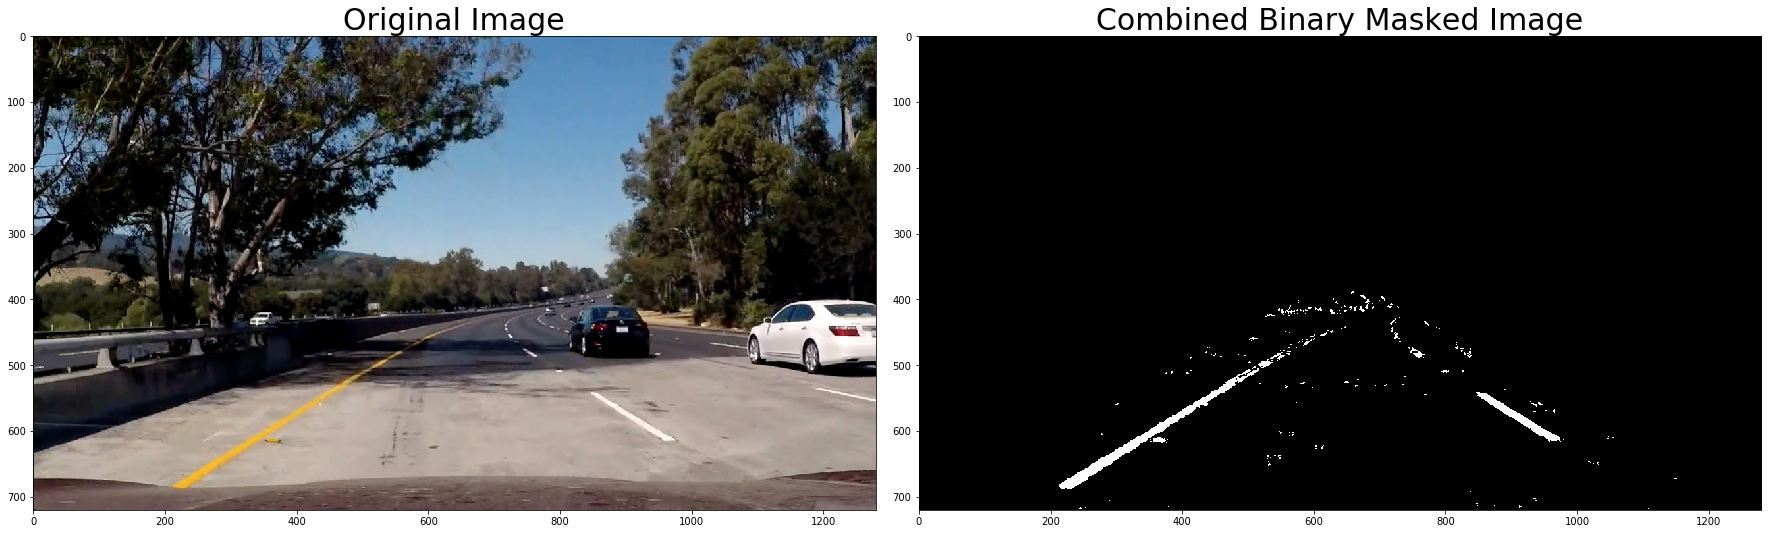

In [7]:
img = mpimg.imread('test_images/test5.jpg')
img_size = img.shape
#print(img_size)
binary_img = get_binary_image(img, useColor=False, useGradient=True, useMagnitude=True, useDirection=True)
masked_binary_img = get_masked_binary_img(img, binary_img)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(masked_binary_img, cmap='gray')
ax2.set_title('Combined Binary Masked Image', fontsize=30)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [8]:
# Vertices extracted manually for performing a perspective transform
src_bottom_left = [240,660]
src_bottom_right = [1160, 660]
src_top_left = [570, 470]
src_top_right = [760, 470]

dest_bottom_left = [320,660]
dest_bottom_right = [920, 660]
dest_top_left = [320, 1]
dest_top_right = [920, 1]

In [9]:
def get_birds_eye_view_img(masked_binary_img):
    src = np.float32([src_bottom_left, src_bottom_right, src_top_right, src_top_left])
    dst = np.float32([dest_bottom_left, dest_bottom_right, dest_top_right, dest_top_left])

    M = cv2.getPerspectiveTransform(src, dst)
    M_inv = cv2.getPerspectiveTransform(dst, src)

    img_size = (masked_binary_img.shape[1], masked_binary_img.shape[0])
    warped_img = cv2.warpPerspective(masked_binary_img, M, img_size , flags=cv2.INTER_LINEAR)
    
    return warped_img, M, M_inv

In [10]:
def plot_birds_eye_view_img(warped_img):  
    
    plot_pts = np.array([src_bottom_left, src_bottom_right, src_top_right, src_top_left], np.int32)
    plot_pts = plot_pts.reshape((-1,1,2))
    img_copy = img.copy()
    cv2.polylines(img_copy,[plot_pts],True,(255,0,0), thickness=3)
    
    plot_pts = np.array([dest_bottom_left, dest_bottom_right, dest_top_right, dest_top_left], np.int32)
    plot_pts = plot_pts.reshape((-1,1,2))
    warped_img_copy = warped_img.copy()
    cv2.polylines(warped_img_copy,[plot_pts],False,(255,0,0), thickness=3)

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_copy)
    ax1.set_title('Original Image', fontsize=30)
    ax2.imshow(warped_img, cmap='gray')
    ax2.set_title('Bird\'s Eye View - Warped Image', fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

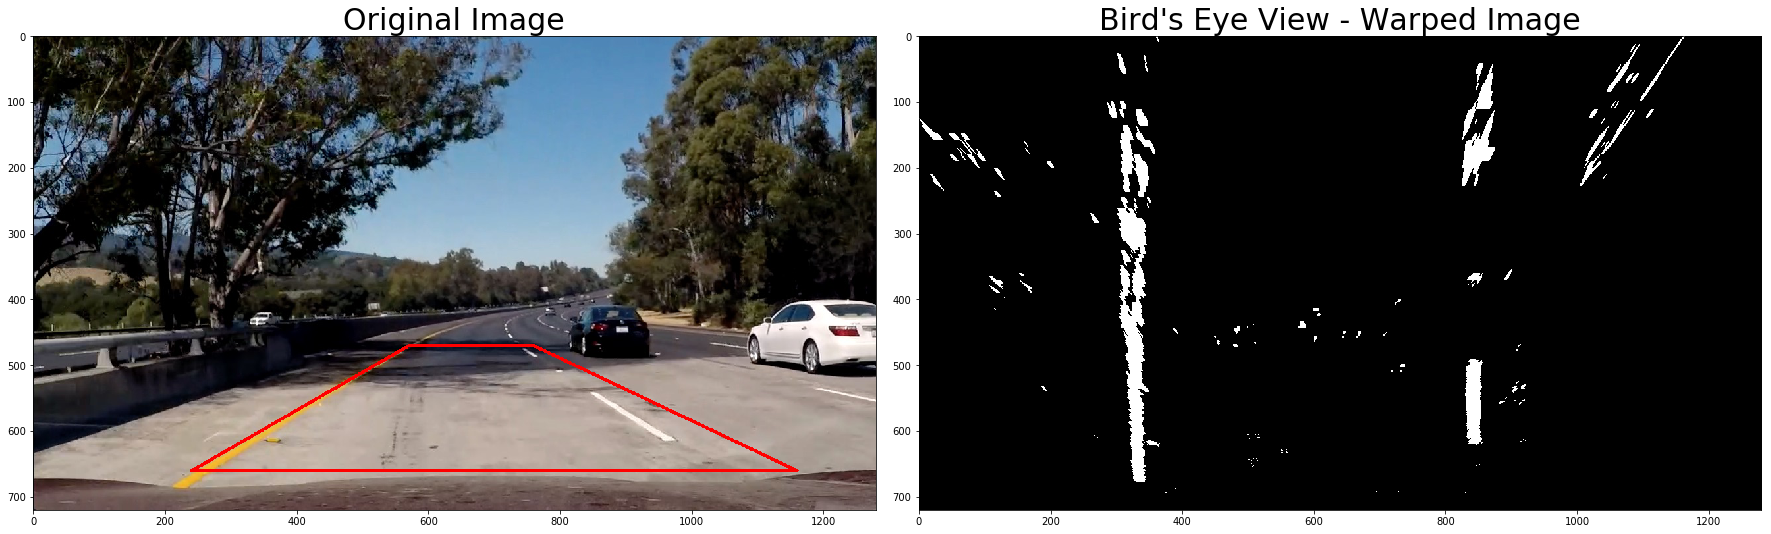

In [11]:
warped_img, M, M_inv = get_birds_eye_view_img(masked_binary_img)
#warped_img = get_warped_img(img)
plot_birds_eye_view_img(warped_img)

In [12]:
from Lane import *
lane = None

In [13]:
def findLanes(birds_eye_view_img, M_inv, img):
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(birds_eye_view_img.shape[0]/nwindows)
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    if not lane.is_lane_detected:    
        # Assuming you have created a warped binary image called "birds_eye_view_img"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(birds_eye_view_img[birds_eye_view_img.shape[0]//2:,:], axis=0)
        
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint
        
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = birds_eye_view_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base

        # Create empty lists to receive left and right lane pixel indices or coordinates
        left_lane_coords = []
        right_lane_coords = []
    
        # Step through the windows one by one
        for window in range(nwindows):
            win_y_low = birds_eye_view_img.shape[0] - (window+1)*window_height
            win_y_high = birds_eye_view_img.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            
            '''
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            '''
            
            # Identify the nonzero (good) pixels in x and y within the window
            good_left_coords = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_coords = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            
            # Append these indices to the lists
            left_lane_coords.append(good_left_coords)
            right_lane_coords.append(good_right_coords)

            if len(good_left_coords) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_coords]))
            if len(good_right_coords) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_coords]))
        
        # Concatenate the arrays of indices
        left_lane_coords = np.concatenate(left_lane_coords)
        right_lane_coords = np.concatenate(right_lane_coords)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_coords]
        lefty = nonzeroy[left_lane_coords] 
        rightx = nonzerox[right_lane_coords]
        righty = nonzeroy[right_lane_coords] 

        # Fit a second order polynomial to each
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        # Update Lane 
        lane.update_lane_coords(left_fit, right_fit)
        lane.is_lane_detected = True
    else:
        nonzero = birds_eye_view_img.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])

        left_fit = lane.left_fit
        right_fit = lane.right_fit
        left_lane_coords = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
        right_lane_coords = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_coords]
        lefty = nonzeroy[left_lane_coords] 
        rightx = nonzerox[right_lane_coords]
        righty = nonzeroy[right_lane_coords]

        # Fit a second order polynomial to each
        lane.update_lane_coords(np.polyfit(lefty, leftx, 2), np.polyfit(righty, rightx, 2))
        left_fit = lane.left_fit
        right_fit = lane.right_fit
           
    ploty = np.linspace(0, birds_eye_view_img.shape[0]-1, birds_eye_view_img.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return ploty, left_fitx, right_fitx

In [14]:
def draw_driving_area(img, warped_img, M_inv, ploty, left_fitx, right_fitx):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_img).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0)) #R=0;G=255;B=0

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, M_inv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    #result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    return result

In [15]:
def get_radius_of_curvature(ploty, left_fitx, right_fitx):
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curve_rad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curve_rad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    radius_of_curvature = (left_curve_rad + right_curve_rad)/2
    #print(left_curverad, 'm', right_curverad, 'm')
    return left_curve_rad, right_curve_rad, radius_of_curvature

In [16]:
def get_center_shift(img, left_fitx, right_fitx):
    center_of_lane = (left_fitx[719] + right_fitx[719])/2
    
    '''
    img_size = img.shape
    left_c = lane.left_fit[0] * img_size[0] ** 2 + lane.left_fit[1] * img_size[0] + lane.left_fit[2]
    right_c = lane.right_fit[0] * img_size[0] ** 2 + lane.right_fit[1] * img_size[0] + lane.right_fit[2]
    width = right_c - left_c
    xm_per_pix = 3.7 / width
    '''
    
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    center_shifted_in_pixels = abs(img.shape[1]/2 - center_of_lane)
    center_shifted_in_meters = xm_per_pix * center_shifted_in_pixels
    return center_shifted_in_meters


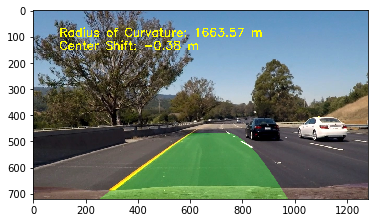

In [22]:
from Lane import *
lane = Lane()

img = mpimg.imread('test_images/test6.jpg')
test_img = 'test_images/test6.jpg'

undistorted_img = calibrate_camera_and_get_undistorted_img('camera_cal/calibration*.jpg', test_img)# function that returns undistorted image
binary_img = get_binary_image(img, useColor=False, useGradient=True, useMagnitude=True, useDirection=True) #function that returns binary image (img_binary) with combination of all thresholds images (img_stack) - it will be displayed near process frame later
masked_binary_img = get_masked_binary_img(img, binary_img)
birds_eye_view_img, M, M_Inv = get_birds_eye_view_img(masked_binary_img) # function that returns birds-eye view
ploty, left_fitx, right_fitx = findLanes(birds_eye_view_img, M_inv, img)

#get_radius_of_curvature
left_curve_rad, right_curve_rad, radius_of_curvature = get_radius_of_curvature(ploty, left_fitx, right_fitx)
curvature_radius_string = "Radius of Curvature: %.2f m" % radius_of_curvature

#get_center_shift
center_shift = lane.get_position_from_center()
#get_center_shift(img, left_fitx, right_fitx)

center_shift_string = "Center Shift: %.2f m" % center_shift  

result = draw_driving_area(img, birds_eye_view_img, M_inv, ploty, left_fitx, right_fitx)

cv2.putText(result, curvature_radius_string, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
cv2.putText(result, center_shift_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
    
#print(lane)
plt.imshow(result)
plt.show()

In [23]:
def adv_detect_lanes_pipeline(img):
    
    lane = Lane()
    binary_img = get_binary_image(img, useColor=False, useGradient=True, useMagnitude=True, useDirection=True) #function that returns binary image (img_binary) with combination of all thresholds images (img_stack) - it will be displayed near process frame later
    masked_binary_img = get_masked_binary_img(img, binary_img)
    birds_eye_view_img, M, M_Inv = get_birds_eye_view_img(masked_binary_img) # function that returns birds-eye view
    ploty, left_fitx, right_fitx = findLanes(birds_eye_view_img, M_inv, img)

    #get_radius_of_curvature
    left_curve_rad, right_curve_rad, radius_of_curvature = get_radius_of_curvature(ploty, left_fitx, right_fitx)
    curvature_radius_string = "Radius of Curvature: %.2f m" % radius_of_curvature
    
    #get_center_shift
    center_shift = get_center_shift(img, left_fitx, right_fitx)
    center_shift_string = "Center Shift: %.2f m" % center_shift  

    result = draw_driving_area(img, birds_eye_view_img, M_inv, ploty, left_fitx, right_fitx)

    cv2.putText(result, curvature_radius_string, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
    cv2.putText(result, center_shift_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
    
    '''
    # To debug frame by frame when processing video frames, uncomment the plt commands below
    plt.imshow(result)
    plt.show()
    '''
    return result

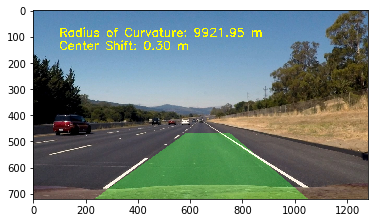

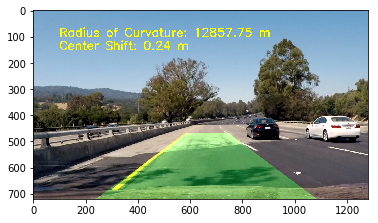

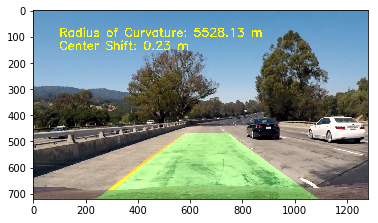

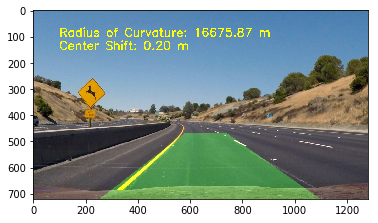

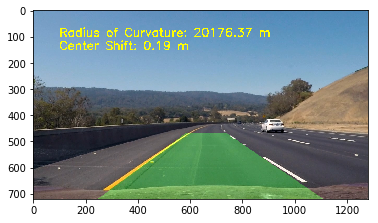

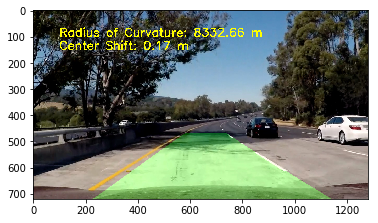

In [24]:
#Declarations
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#Testing Single Image
#img = mpimg.imread('test_images/test1.jpg')
#result = adv_lane_detection_pipeline2(img)

TEST_IMAGES = 'test_images/*'
test_images = glob.glob(TEST_IMAGES)
#undistorted_img = calibrate_camera_and_undistort()# function that returns undistorted image
#calibration_imgs_path = 'camera_cal/calibration*.jpg'

for idx, fname in enumerate(test_images):
    img = mpimg.imread(fname)
    result = adv_detect_lanes_pipeline(img)
    
    plt.imshow(result)
    plt.show()


In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'Advanced_Lane_Detection_New.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(adv_detect_lanes_pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video Advanced_Lane_Detection_New.mp4
[MoviePy] Writing video Advanced_Lane_Detection_New.mp4


100%|█████████▉| 1260/1261 [03:38<00:00,  5.86it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Advanced_Lane_Detection_New.mp4 

CPU times: user 3min 43s, sys: 1min 8s, total: 4min 51s
Wall time: 3min 38s


In [ ]:
# Process pipeline with aditional information
def process_image_ex(img):
    undistorted_img = calibrate_camera_and_undistort()# function that returns undistorted image
    binary_img = get_binary_image(img, useColor=False, useGradient=True, useMagnitude=True, useDirection=True) #function that returns binary image (img_binary) with combination of all thresholds images (img_stack) - it will be displayed near process frame later
    masked_binary_img = get_masked_binary_img(img, binary_img)
    birds_eye_view_img, M, M_Inv = get_birds_eye_view_img(masked_binary_img) # function that returns birds-eye view
    
    #lanes, ploty, left_fitx, right_fitx = # function that detects lines and lane
    ploty, left_fitx, right_fitx = findLanes(birds_eye_view_img, M_inv, img)

    left_curverad, right_curverad, radius_of_curvature = get_radius_of_curvature(ploty, left_fitx, right_fitx) #function that returns radius of curvature and distance from center
    curvature_radius_string = "Radius of Curvature: %.2f m" % radius_of_curvature
    
    center_dist = get_center_shift(img, left_fitx, right_fitx)
    center_shift_string = "Center Shift: %.2f m" % center_dist  
    
    cv2.putText(result, curvature_radius_string, (100, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
    cv2.putText(result, center_shift_string, (100, 150), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255,255,0), thickness=3)
    
    output = draw_driving_area(img, birds_eye_view_img, M_inv, ploty, left_fitx, right_fitx)
    output1 = cv2.resize(birds_eye_view_img,(640, 360), interpolation = cv2.INTER_AREA)
    #output2 = cv2.resize(lanes,(640, 360), interpolation = cv2.INTER_AREA)
    output2 = cv2.resize(birds_eye_view_img,(640, 360), interpolation = cv2.INTER_AREA)

    # Create an array big enough to hold both images next to each other.
    vis = np.zeros((720, 1280+640, 3))

    # Copy both images into the composed image.
    vis[:720, :1280,:] = output
    vis[:360, 1280:1920,:] = output1
    vis[360:720, 1280:1920,:] = output2

    return vis

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output = 'Advanced_Lane_Detection_New.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(process_image_ex) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(video_output, audio=False)